# European cardholders 2013(September) Transaction Data- Identify fraudulent credit card transactions
#### By: Swati Kohli

### Introduction
This notebook evaluates input variables which are the result of a PCA transformation of transactions(privacy concerns) that occurred in two days. Various predictive models are used to see how accurate they are in detecting whether a transaction is a normal payment or a fraud. 
The goal is to compare 5 models, and see which gives the best performance. To be fair, evaluation is performed using the same holdout set. The five models are:
1. Logistic Regression
2. Decision Tree
3. Bagged Trees
4. Random Forest
5. Boosted Trees

The dataset is highly unbalanced due to which accuracy is not a good metric to use here. Therefore, F1-score is used for hyperparameter selection for all models. ROC curve and AUC score is also used because it is a good method to use when comparing multiple classification algorithms.

In [1]:
# Import relevant libraries 
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# Load the data set
fraud = pd.read_csv('fraud.csv')
fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,149938,-0.445664,0.565437,0.733374,-0.999763,1.609578,1.187041,1.452018,-0.198439,-0.048416,...,-0.195318,-0.107752,-0.100277,-0.329253,-0.375723,0.275200,-0.349132,-0.338845,50.19,0
1,148077,0.111788,1.124121,-0.191350,-0.443245,0.777409,-1.071823,1.068130,-0.203815,-0.246504,...,-0.297632,-0.660398,0.144101,1.072859,-0.444134,0.079985,0.229395,0.091531,5.37,0
2,121831,2.087566,-1.134330,-0.593377,-1.058366,-1.104703,-0.413032,-1.112383,0.110687,-0.074055,...,0.053867,-0.082683,0.328018,-0.543838,-0.593097,-0.466010,-0.010324,-0.052221,40.00,0
3,75683,-0.488630,1.039124,1.413263,0.110440,0.205570,-0.721798,0.677329,-0.007125,-0.568263,...,-0.189721,-0.439538,0.084214,0.374691,-0.235030,0.077754,0.262267,0.102935,12.99,0
4,46080,-1.018049,0.727356,1.723606,-1.409580,0.255078,-0.648925,0.807408,0.190881,-0.605563,...,-0.425400,-1.383973,0.085528,0.175845,-0.104718,0.462432,0.159748,0.099125,19.99,0


The data contains 31 columns. The first 30 columns are predictors and the last column (Class) is response. There are no variable names to these columns, since they are PCA transformation of an even earlier data set. For this analysis, Time column is removed.  


In [4]:
# Remove the Time column
fraud.drop('Time', axis = 1, inplace = True)

# Look at distribution of Class variable
fraud.Class.value_counts()

0    2500
1     492
Name: Class, dtype: int64

Let's look at the distribution of the Class variable.

In [5]:
# Separate predictors and response
X = fraud.drop('Class', axis = 1)
y = fraud.Class

# Split data into training and holdout set. 
# Random state 1 and test size of 30%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

Train each of the 5 models using the training set. Tuning at least one hyperparameter and using the same tuning strategy across the 5 models.

In [6]:
# Import libraries 
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.tree import DecisionTreeClassifier #Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # Bagging
from sklearn.ensemble import GradientBoostingClassifier # Boosting

# Tuning strategy
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import f1_score # evaluation metrics 1

from sklearn.metrics import roc_curve, roc_auc_score # evaluation metrics 2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix

import time # For time evaluation

### Approach
Following 4 step approach for all 5 methods
1. Instantiate
2. Set up hyperparamters to tune (Regularization or alpha tuning for first 2 and estimator or no. of trees for next 3 methods.)
3. Use CV gridsearch with 5 folds for all methods to find best hyperparameters. 
4. Fit the training dataset and get best hyperparameters for that model
5. Record time taken for each method for general comparison.

In [7]:
#    ******** Method 1 : Logistic Regression ******** 
# Train and tune Logistic Regression
# Regularised Regression, Set up pipeline and grid search

#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression

start = time.time() # record start time
estimator = Pipeline( [('scale', StandardScaler()),
                      ('clf', LogisticRegression(penalty = 'l1', 
                                                 solver = 'liblinear', 
                                                 random_state = 1000))] )
grid_lr = {'clf__C': np.logspace(-10, 10, 21),
       'clf__max_iter': np.linspace(1000,10000,10)}

# Gridsearch CV
clf_lr = GridSearchCV(estimator, grid_lr, cv = 5, scoring = 'f1', n_jobs = -1)
clf_lr.fit(X_train, y_train)
end = time.time() # record end time
print('Tuning time in seconds:',end-start)

print("Best hyperparameters are",clf_lr.best_params_)

Tuning time in seconds: 100.15244936943054
Best hyperparameters are {'clf__C': 1.0, 'clf__max_iter': 1000.0}


In [8]:
# Refine search

start1 = time.time() # record start time
grid_lra = {'clf__C': np.logspace(-2, 1, 100), # We will narrow our search around the selected value, and use a much finer grid
       'clf__max_iter': np.linspace(1000,10000,10)}

# Gridsearch CV
clf_lr2 = GridSearchCV(estimator, grid_lra, cv = 5, scoring = 'f1', n_jobs = -1)
clf_lr2.fit(X_train, y_train)
end = time.time() # record end time
print('Tuning time in seconds:',end-start)

print("Refined hyperparameters are",clf_lr2.best_params_)

Tuning time in seconds: 150.25842452049255
Refined hyperparameters are {'clf__C': 0.05722367659350217, 'clf__max_iter': 1000.0}


In [9]:
#    ******** Method 2 : Decision Tree ******** 
# Train and tune Decision Tree

#from sklearn.tree import DecisionTreeClassifier

start = time.time() # record start time
tree_clf =  DecisionTreeClassifier(random_state= 1,min_samples_leaf = 5) # dont need to scale data so have one input
grid_dt = {'ccp_alpha': np.logspace(-2, 1, 100)} 
        
# Gridsearch CV
clf_dt = GridSearchCV(tree_clf, grid_dt, cv = 5, scoring = 'f1', n_jobs = -1)
clf_dt.fit(X_train, y_train)
end = time.time() # record end time
print('Tuning time in seconds:',end-start)

print("Best Alpha is",clf_dt.best_params_)

Tuning time in seconds: 8.830337524414062
Best Alpha is {'ccp_alpha': 0.01}


In [10]:
#    ******** Method 3 : Bagged Tree ******** 
# Train and tune Bagged Tree
# In bagging all features are used in each split

start = time.time() # record start time
bg_clf =  RandomForestClassifier(random_state= 1,min_samples_leaf = 5,max_features=None)
grid_bt = {'n_estimators': np.linspace(100,1000,20, dtype = int),
           'max_depth':range(2, 10)}

# Gridsearch CV
clf_bg = GridSearchCV(bg_clf, grid_bt, cv = 5, scoring = 'f1', n_jobs = -1)
clf_bg.fit(X_train, y_train)
end = time.time() # record end time
print('Tuning time in seconds:',end-start)

print("Best estimator(or number of trees) is",clf_bg.best_params_)

Tuning time in seconds: 2269.7653517723083
Best estimator(or number of trees) is {'max_depth': 7, 'n_estimators': 147}


In [11]:
#    ******** Method 4 : Random Forest ******** 
# Train and tune Random Forest
# In Random Forest add random subspace method all features are used in each split

start = time.time() # record start time
rf_clf = RandomForestClassifier(random_state= 1,min_samples_leaf = 5)
grid_rt = {'n_estimators': np.linspace(100, 1000, 10, dtype = int),'max_features':['sqrt','log2'] }

# Gridsearch CV
clf_rt = GridSearchCV(rf_clf, grid_rt, cv = 5, n_jobs = -1, scoring = 'f1')
clf_rt.fit(X_train, y_train)
end = time.time() # record end time
print('Tuning time in seconds:',end-start)

print("Best hyper parameters are",clf_rt.best_params_)

Tuning time in seconds: 93.29063391685486
Best hyper parameters are {'max_features': 'sqrt', 'n_estimators': 100}


In [12]:
#    ******** Method 5 : Boosted Trees ******** 
# Train and tune Boosted Trees

start = time.time() # record start time
bt_clf = GradientBoostingClassifier(random_state= 1,min_samples_leaf = 5)
grid_bt = {'n_estimators': np.linspace(100, 1000, 10, dtype = int),'learning_rate': np.linspace(0.01,0.1,5)}

# Gridsearch CV
clf_bt = GridSearchCV(bt_clf, grid_bt, cv = 5, n_jobs = -1, scoring = 'f1')
clf_bt.fit(X_train, y_train)
end = time.time() # record end time
print('Tuning time in seconds:',end-start)

print("Best hyper parameters are",clf_bt.best_params_)

Tuning time in seconds: 567.5045502185822
Best hyper parameters are {'learning_rate': 0.05500000000000001, 'n_estimators': 200}


Perform prediction on all 5 models using the holdout set, and report the F1 score.

In [13]:
#from sklearn.metrics import f1_score
print("f1 scores on the test set are:")
print("Logistic Regression",f1_score(y_test,clf_lr2.predict(X_test)))
print("Decision Tree      ",f1_score(y_test,clf_dt.predict(X_test)))
print("Bagging            ",f1_score(y_test,clf_bg.predict(X_test)))
print("Random Forest      ",f1_score(y_test,clf_rt.predict(X_test)))
print("Boosting           ",f1_score(y_test,clf_bt.predict(X_test)))

f1 scores on the test set are:
Logistic Regression 0.898876404494382
Decision Tree       0.8614232209737829
Bagging             0.8856088560885609
Random Forest       0.8913857677902622
Boosting            0.8905109489051095


**Observation**  
**Logistic regression model** has the best performance, followed by **Random Forest** then **Boosting** and **Bagging**. Also, the time taken by Bagged tree and Boosting is the most but Logistic Regression is quite low comparatively yet providing a better f1 score.
As expected, a single **Decision Tree** doesn't perform too well and gives lowest f1 score out of the five.

ROC curve is a good method to use when comparing multiple classification algorithms.
Therefore, plotting the ROC curves of these 5 classifiers on the same graph:

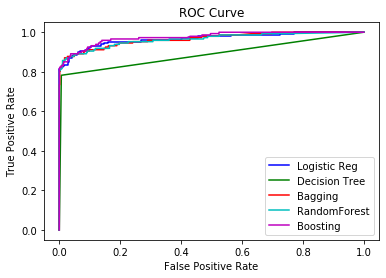

In [14]:
# ROC Curves

# get y_score values
y_prob1 = clf_lr2.predict_proba(X_test)[:,1]
y_prob2 = clf_dt.predict_proba(X_test)[:,1]
y_prob3 = clf_bg.predict_proba(X_test)[:,1]
y_prob4 = clf_rt.predict_proba(X_test)[:,1]
y_prob5 = clf_bt.predict_proba(X_test)[:,1]

# Setup ROC curve, y_true vs y_score
vals1 = roc_curve(y_test, y_prob1, pos_label = 1) 
vals2 = roc_curve(y_test, y_prob2, pos_label = 1) 
vals3 = roc_curve(y_test, y_prob3, pos_label = 1)
vals4 = roc_curve(y_test, y_prob4, pos_label = 1)
vals5 = roc_curve(y_test, y_prob5, pos_label = 1)

# plot graph for all methods
plt.plot(vals1[0], vals1[1],color = 'b', label = 'Logistic Reg')
plt.plot(vals2[0], vals2[1],color = 'g', label = 'Decision Tree')
plt.plot(vals3[0], vals3[1],color = 'r', label = 'Bagging')
plt.plot(vals4[0], vals4[1],color = 'c', label = 'RandomForest')
plt.plot(vals5[0], vals5[1],color = 'm', label = 'Boosting')

# plt.ylim(0.7,1.01) # Zoom in to see overlapping lines closely but no help and need AUC score

# add labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Observation**  
The ROC curves show that Decision Tree has minimum area under curve (diagonal line worst scenario because it is as good as guessing). The other 4 methods perform much better and it is observed that the area is somewhere between 0.8 to 1 for all of them. AUC score will give a better idea about the maximum area under curve which is an indicator of the best model.

In [15]:
# AUC values
print ("AUC Scores are:")
print("Logistic Reg: ", roc_auc_score(y_test, y_prob1))
print("Decision Tree:", roc_auc_score(y_test, y_prob2))
print("Bagging:      ", roc_auc_score(y_test, y_prob3))
print("Random Forest:", roc_auc_score(y_test, y_prob4))
print("Boosting:     ", roc_auc_score(y_test, y_prob5))

AUC Scores are:
Logistic Reg:  0.9668288087538611
Decision Tree: 0.8878275677781098
Bagging:       0.9656874733914871
Random Forest: 0.9640479360852197
Boosting:      0.9753707075373423


**Observation**  
Model with largest Area Under Curve(AUC) is the best classification model.Boosting gives the best score out of all for the classification model.
Although the scoring is very close, the order of best classification as per AUC score is **Boosting** followed by **Logistic Regression** then **Bagging** and then **Random Forest**.
**Decision Tree** still has the lowest AUC (As seen in the graph as well).

In [16]:
# Confusion matrix
from sklearn.metrics import confusion_matrix # create confusion matrix

yhat = clf_bt.predict(X_test)
confmat = confusion_matrix(y_true= y_test, y_pred= yhat, labels = [1,0])       
print("Final Confusion Matrix \n",confmat)

Final Confusion Matrix 
 [[122  25]
 [  5 746]]


**Conclusion**  
Model selection based on f1 score and AUC score give different results because their criteria for a good model are different.

f1 does not take the true negatives into account and is a measure of precision and recall at a particular threshold value. High 
f1 implies both precision and recall are high.

f1-score： 2/(1/P+1/R) where  
Precision: TP/(TP+FP)  
Recall: TP/(TP+FN)

ROC/AUC： TPR=TP/(TP+FN), FPR=FP/(FP+TN)

For data like this as fraud detection, the positive examples(frauds) have relatively low rates of occurrence.
Due to this unbalance in data f1 score gets affected but not ROC/AUC. With imbalanced data, the AUC still gives value around 0.8. However, it is high due to large FP, rather than the large TP (True positive).
Therefore, f1 is a better evaluation metric in this case.
Roc/Auc is good with balanced distribution of positives and negatives in dataset.